## About this tutorial 

In my post about [handwritten digit recognition with scikit-learn](https://thedatafrog.com/handwritten-digit-recognition-scikit-learn/), we have seen that [scikit-learn](https://scikit-learn.org) makes it easy to train a simple neural network. 

scikit-learn focuses on providing a unified interface for training and testing many machine learning algorithms: neural networks, support-vector machines, naive Bayes, nearest neighbours, decision trees, etc. Indeed, in machine learning, a large amount of time is spent choosing the best algorithm and tuning it for best performance. Scikit-learn was designed to make these operations as easy as possible.  

However, when it comes to neural networks specifically, scikit-learn has three major drawbacks:

* the interface does not provide enough control to build complex neural networks
* a lot of magic happens under the hood, like regularization
* it's not adapted to [deep learning](https://thedatafrog.com/install-tensorflow-windows/)

In this post, we will repeat our exercise about handwritten digit recognition with [Keras](https://keras.io/), a high-level neural networks API. You will learn how to: 

* Create a simple dense neural network with Keras
* Estimate its performance 

Later on, we will use Keras as an interface to TensorFlow to do deep learning. 

**Prerequisites:** You should have some knowledge of:

* numpy, 
* matplotlib, 
* jupyter notebooks,
* basic neural networks. 

If that's not yet the case, you can follow [handwritten digit recognition with scikit-learn](https://thedatafrog.com/handwritten-digit-recognition-scikit-learn/).


## Installation

First, install [Anaconda](https://www.anaconda.com/download/) if not already done. Please be sure to **pick the version for python 2.X and not for python 3.X**.

Launch the Anaconda Navigator application. 

Enter the Environments tab, and install the keras package in your base (root) environment. 

Solving the package specifications for keras may take a few minutes but you'll eventually get there.

Then, head to the Home tab, and launch the jupyter notebook. 



Finally, get this notebook and open it in the jupyter notebook:

* [download the repository containing this notebook](https://github.com/cbernet/maldives/archive/master.zip)
* unzip it, say to `Downloads/maldives-master`
* in the jupyter notebook, navigate to `Downloads/maldives-master/handwritten_digits_keras`
* open `handwritten_digits_keras.ipynb`

This page should appear in the notebook. From now on, follow the tutorial in the notebook. You should execute the cells as they come, or execute them all in one go. You can even add cells or modify existing cells to experiment a bit. 

## Preparing the dataset 

As in [handwritten digit recognition with scikit-learn](https://thedatafrog.com/handwritten-digit-recognition-scikit-learn/), we are going to use the digits dataset provided by scikit-learn. The digits are 8x8 images that are fed into a neural network with:

* an input layer with 8x8 = 64 neurons
* a hidden layer with 15 neurons
* an output layer with 10 neurons corresponding to the 10 digit categories. 

First, let's initialize our tools and load the digits dataset: 

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os 
# for some reason, the following is needed to run on mac os
os.environ['KMP_DUPLICATE_LIB_OK']='True'  

from sklearn import datasets
digits = datasets.load_digits()

The input layer requires a 1-dimensional array in input, but our images are 2D. So we need to flatten all images:

In [30]:
x = digits.images.reshape((len(digits.images), -1))
x.shape

(1797, 64)

The labels require a bit of attention. At the moment, `digits.target` contains the digit corresponding to each image in the dataset: 

In [31]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

But in Keras, we have to build our neural network with 10 output neurons (this actually happens under the hood in scikit-learn). During the training, Keras will have to compare the 10 output values of these neurons to the target value. But how can we compare a vector of 10 values with a single target value? 

The solution is to translate each target value into a vector of length 10 with a technique called *one-hot encoding*: 

* target `0` is translated to `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`
* target `1` is translated to `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`
* ...
* target `9` is translated to `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]`

After doing that, the values from the output neurons, which are probabilities ranging from 0 to 1, can be compared directly to the values in the target vector. In this way, for a given number, say 0, the neural network will be trained to output a high probability from the first output neuron, and a low probability from the following neurons.  

One-hot encoding can be performed easily with the utilities provided by Keras: 

In [32]:
from keras.utils import np_utils
y = np_utils.to_categorical(digits.target,10)
print digits.target
print y

[0 1 2 ... 8 9 8]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


let's now split our data into a training sample and a testing sample:

In [33]:
split_limit=1000
x_train = x[:split_limit]
y_train = y[:split_limit]
x_test = x[split_limit:]
y_test = y[split_limit:]

The first 1000 images and labels are going to be used for training. The rest of the dataset will be used later to test the performance of our network. 

We can now create the neural network. We use one hidden layers with 15 neurons. The output layer must have exactly 10 neurons because we want to classify our digits in 10 categories. Don't pay attention to the other parameters, we'll cover that in future posts.

In [34]:
from keras import layers, Model, optimizers, regularizers

In [89]:
# create the input layer
# 
# we specify that the input layer 
# should have 64 neurons, one for each pixel
# in our images. 
# The input neurons do nothing, they 
# just transfer the value at each pixel 
# to the next layer. 
img_input = layers.Input(shape=(64,))

# create the hidden layer
#
# This layer is a Dense layer, which means
# that its neurons are fully connected to the 
# neurons in the previous layer (the input layer)
# We will talk about the activation in a future post
tmp = layers.Dense(15, 
                   activation='sigmoid')(img_input)

# create the output layer
# 
# The output layer is another Dense layer.
# It must have 10 neurons, corresponding to 
# the 10 digit categories 
output = layers.Dense(10, 
                      activation='sigmoid')(tmp)

# create the neural network from the layers
model = Model(img_input, output)

# print a summary of the model
model.summary()

# =================================================
# Please don't pay attention to what follows, 
# we'll talk about regularization later!
# For now, it is enough to know that regularization
# helps the neural network converge properly. 
# A similar regularization is performed 
# under the hood by the MLPClassifier of scikit-learn
l2_rate = 1e-4
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = regularizers.l2(l2_rate)
        layer.bias_regularizer = regularizers.l2(l2_rate)
        layer.activity_regularizer = regularizers.l2(l2_rate)
# =================================================

# define how the neural network will learn, 
# and compile the model. 
# models must be compiled before 
# they can be trained and used. 
# the loss, optimizer, and metrics arguments 
# will be covered in a future post. 
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.1, momentum=0.9),
              metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 15)                975       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                160       
Total params: 1,135
Trainable params: 1,135
Non-trainable params: 0
_________________________________________________________________


In [90]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test),
                    batch_size=100, epochs=50)

Train on 1000 samples, validate on 797 samples
Epoch 1/50
1000/1000 [==============================] - 0s 489us/step - loss: 2.2343 - acc: 0.1630 - val_loss: 2.1267 - val_acc: 0.2422
Epoch 2/50
1000/1000 [==============================] - 0s 34us/step - loss: 2.0033 - acc: 0.4120 - val_loss: 1.9296 - val_acc: 0.5031
Epoch 3/50
1000/1000 [==============================] - 0s 41us/step - loss: 1.7382 - acc: 0.7150 - val_loss: 1.6102 - val_acc: 0.7453
Epoch 4/50
1000/1000 [==============================] - 0s 35us/step - loss: 1.3686 - acc: 0.8250 - val_loss: 1.2430 - val_acc: 0.7779
Epoch 5/50
1000/1000 [==============================] - 0s 33us/step - loss: 0.9886 - acc: 0.8710 - val_loss: 0.9270 - val_acc: 0.8494
Epoch 6/50
1000/1000 [==============================] - 0s 33us/step - loss: 0.7071 - acc: 0.9170 - val_loss: 0.7399 - val_acc: 0.8758
Epoch 7/50
1000/1000 [==============================] - 0s 32us/step - loss: 0.5301 - acc: 0.9340 - val_loss: 0.6203 - val_acc: 0.8733
Epoch 8

## Evaluating the performance

The predictions from the neural network are evaluated for all examples in the test sample by doing

In [91]:
predictions = model.predict(x_test)
print predictions[0]

[6.08958544e-06 6.47348836e-02 1.08900410e-03 4.90986058e-05
 3.76566604e-05 5.68168689e-05 6.44402462e-05 4.70710074e-06
 1.03775405e-04 3.53699434e-05]


For each sample, the prediction is an array of 10 values. Each value is the estimated probability for the image to belong to this category. 

The predicted category is the one with the largest probability. 

Let's write a small function to plot a given image, and to print the true and predicted categories:

In [92]:
def plot_prediction(index):
    print 'predicted probabilities:'
    print predictions[index]
    print 'predicted category', np.argmax(predictions[index])
    print 'true probabilities:'
    print y_test[index]
    print 'true category', np.argmax(y_test[index])
    img = x_test[index].reshape(8,8)
    plt.imshow(img)

In this function, we obtain the category with `np.argmax` that, for an array, returns the index corresponding to the largest value. 

Let's use this function to have a look at a few examples (just choose a different index to look at another example).

predicted probabilities:
[6.08958544e-06 6.47348836e-02 1.08900410e-03 4.90986058e-05
 3.76566604e-05 5.68168689e-05 6.44402462e-05 4.70710074e-06
 1.03775405e-04 3.53699434e-05]
predicted category 1
true probabilities:
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
true category 1


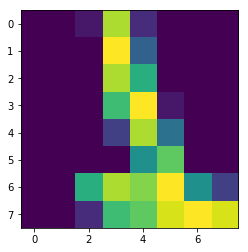

In [93]:
plot_prediction(0)

Finally, let's compute the accuracy score, which is the probability to classify the digits correctly.

We will compute the accuracy for the test sample, which has not been used to train the network. Again, we will use `np.argmax` to get the predicted and true categories for each example.

In [94]:
# the second argument of argmax specifies
# that we want to get argmax for each example. 
# without this argument, argmax would return 
# the largest value in the whole array,
# considering all examples
y_test_best = np.argmax(y_test,1)
print y_test_best.shape
predictions_best = np.argmax(predictions,1)

from sklearn.metrics import accuracy_score
accuracy_score(y_test_best, predictions_best)

(797,)


0.9372647427854455

You should obtain an accuracy around 92%, similar to the one we had obtained in the same conditions with scikit-learn. 

Please note that the result is not deterministic, so the accuracy will vary every time you train the network. I usually get an accuracy between 90 and 93%. 

Please repeat the exercise starting from the creation of the neural network to see what happens. 